# Project 3: Identifying Depression in r/domesticviolence Subreddit Posts
<img src="./images/domestic_violence.jpg" alt="domestic violence pic"/>

- [Webscraping and Data Collection](./1_Webscraping_and_Data_Collection.ipynb)
- <b>Preprocessing and EDA</b>
- [Modeling - Multinomial Naive Bayes](./3_Modeling_Multinomial_Naive_Bayes.ipynb)
- [Modeling - Logistic Regression](./4_Modeling_Logistic_Regression.ipynb)
- [Modeling - Random Forest](./5_Modeling_Random_Forest.ipynb)
- [Production Model and Insights](./6_Production_Model_and_Insights.ipynb)

---
## Overview

In this notebook, I will conduct data cleaning on the dataset and conduct preprocessing on the columns containing words of posts (```selftext```) and words of titles (```title```). I will then conduct exploratory data analysis to find the top words in posts and titles in both r/domesticviolence and r/depression, and conduct feature engineering to create feature matrixes for the modeling process.  

---
## Contents
- [Data cleaning](#Data-cleaning)
- [Summary statistics](#Summary-statistics)
- [Preprocessing](#Preprocessing)
- [Exploratory data analysis](#Exploratory-data-analysis)
- [Feature engineering](#Feature-engineering-for-modeling)
- [Conclusion](#Conclusion)

In [1]:
#importing libraries
import pandas as pd 
import numpy as np 
import regex as re
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
import matplotlib.pyplot as plt 
import seaborn as sns 
from sklearn.feature_extraction.text import CountVectorizer
from wordcloud import WordCloud

In [2]:
#importing data
domestic_violence = pd.read_csv('./data/domestic_violence_raw.csv')
depression = pd.read_csv('./data/depression_raw.csv')

---
## Data cleaning
Data cleaning comprises of:
- Removing irrelevant columns
- Concatenating domestic_violence and depression dataframes
- Dealing with missing values

### Issue of outliers 
Since it is a NLP model, all words should be taken into account and not removed

In [3]:
domestic_violence.head(2)

,approved_at_utc,subreddit,selftext,author_fullname,saved,mod_reason_title,gilded,clicked,title,link_flair_richtext,...,url,subreddit_subscribers,created_utc,num_crossposts,media,is_video,link_flair_template_id,post_hint,preview,is_depression
0,NaN,domesticviolence,We know many of you are struggling to manage w...,t2_2egrzrvq,False,NaN,0,False,COVID-19 RESOURCES FOR ABUSE VICTIMS,[],...,https://www.reddit.com/r/domesticviolence/comm...,10666,1.585710e+09,1,NaN,False,NaN,NaN,NaN,0
1,NaN,domesticviolence,Maybe this doesnt belong here Im not sure wher...,t2_6dnmfknj,False,NaN,0,False,Im stupid. How long to feel better after minor...,[],...,https://www.reddit.com/r/domesticviolence/comm...,10666,1.592630e+09,0,NaN,False,7d985224-5cda-11ea-aa5c-0e4c53184455,NaN,NaN,0


In [4]:
#choosing subreddit, selftext, title, is_depression columns, dropping the rest

#subreddit refers to the origin subreddit of the post: r/domesticviolence or r/depression
#author_fullname refers to name of author
#self_text contains the contents of the posts 
#title contains the title of the posts
#is_depression is a binary column: is_depression = 1 means r/depression, is_depression = 0 means r/domesticviolence

domestic_violence_depression = domestic_violence[['subreddit', 'author_fullname', 'selftext', 
                                                'title', 'is_depression']]
domestic_violence_depression.head(2)

,subreddit,author_fullname,selftext,title,is_depression
0,domesticviolence,t2_2egrzrvq,We know many of you are struggling to manage w...,COVID-19 RESOURCES FOR ABUSE VICTIMS,0
1,domesticviolence,t2_6dnmfknj,Maybe this doesnt belong here Im not sure wher...,Im stupid. How long to feel better after minor...,0


In [5]:
depression = depression[['subreddit', 'author_fullname', 'selftext', 'title', 'is_depression']]
depression.head()

,subreddit,author_fullname,selftext,title,is_depression
0,depression,t2_1t70,We understand that most people who reply immed...,Our most-broken and least-understood rules is ...,1
1,depression,t2_64qjj,Welcome to /r/depression's check-in post - a p...,Regular Check-In Post,1
2,depression,t2_5xpk5iif,Even if some posts blow up and have a bit of a...,This sub is counterproductive,1
3,depression,t2_564vn2mq,As i go down the rabbit hole of why any of thi...,The more depressed i get the more music i list...,1
4,depression,t2_121smx8c,I miss having someone to love. I miss holding ...,I miss having someone to love,1


In [6]:
#concatenating domestic_violence_suicide and suicide dfs
combined_dv_depression = pd.concat([domestic_violence_depression, depression], axis = 0, 
                               ignore_index = True)
combined_dv_depression.head()

,subreddit,author_fullname,selftext,title,is_depression
0,domesticviolence,t2_2egrzrvq,We know many of you are struggling to manage w...,COVID-19 RESOURCES FOR ABUSE VICTIMS,0
1,domesticviolence,t2_6dnmfknj,Maybe this doesnt belong here Im not sure wher...,Im stupid. How long to feel better after minor...,0
2,domesticviolence,t2_6yb1144r,My main questions are at the bottom if you jus...,Vent but advice/knowledge is appreciated. My b...,0
3,domesticviolence,t2_6zh3tj02,I'm a 34 year old guy who lost his job to covi...,I feel stupid for posting this,0
4,domesticviolence,t2_6zd0zopf,Not sure if what I'm experiencing could be ver...,Is this verbal or emotional abuse or am I over...,0


In [7]:
combined_dv_depression.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1958 entries, 0 to 1957
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   subreddit        1958 non-null   object
 1   author_fullname  1923 non-null   object
 2   selftext         1929 non-null   object
 3   title            1958 non-null   object
 4   is_depression    1958 non-null   int64 
dtypes: int64(1), object(4)
memory usage: 76.6+ KB


In [8]:
#there are 29 null values in 'selftext' and 35 null values in 'author_fullname'
combined_dv_depression.isnull().sum()

subreddit           0
author_fullname    35
selftext           29
title               0
is_depression       0
dtype: int64

In [9]:
#replace null values in 'selftext' with 'nopost'
#replace null values in 'author_fullname' with 'noauthor'
combined_dv_depression['selftext'].fillna('nopost', inplace=True)
combined_dv_depression['author_fullname'].fillna('noauthor', inplace=True)
combined_dv_depression.isnull().sum()

subreddit          0
author_fullname    0
selftext           0
title              0
is_depression      0
dtype: int64

---
## Summary statistics

```combined_dv_depression``` has 1958 posts and 5 columns, each containing information from the posts. 
- ```subreddit```: subreddit the post originated from r/depression or r/domesticviolence 
- ```author_fullname```: user ID of author 
- ```selftext```: words in post 
- ```title```: title of post 
- ```is_depression```: binary column indicating if a post is from r/depression (```is_depression``` = 1) or r/domesticviolence (```is_depression``` = 1)

With the exception of ```is_depression``` whose data type is integer, the rest have object data types which will be converted to a numeric matrix later via vectorization

### Comparing r/depression and r/domesticviolence
- Number of posts 
    - r/depression: 960
    - r/domesticviolence: 998 

Average word count of posts and titles from each subreddit will be calculated during EDA 

In [10]:
combined_dv_depression.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1958 entries, 0 to 1957
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   subreddit        1958 non-null   object
 1   author_fullname  1958 non-null   object
 2   selftext         1958 non-null   object
 3   title            1958 non-null   object
 4   is_depression    1958 non-null   int64 
dtypes: int64(1), object(4)
memory usage: 76.6+ KB


In [11]:
#stats for r/depression
combined_dv_depression[combined_dv_depression['is_depression'] == 1].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 960 entries, 998 to 1957
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   subreddit        960 non-null    object
 1   author_fullname  960 non-null    object
 2   selftext         960 non-null    object
 3   title            960 non-null    object
 4   is_depression    960 non-null    int64 
dtypes: int64(1), object(4)
memory usage: 45.0+ KB


In [12]:
#stats for r/domesticviolence
combined_dv_depression[combined_dv_depression['is_depression'] == 0].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 998 entries, 0 to 997
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   subreddit        998 non-null    object
 1   author_fullname  998 non-null    object
 2   selftext         998 non-null    object
 3   title            998 non-null    object
 4   is_depression    998 non-null    int64 
dtypes: int64(1), object(4)
memory usage: 46.8+ KB


---
## Preprocessing 

In preprocessing, I will tokenize, remove stop words, and lemmatize all words within ```title``` and ```selftext``` and append the processed columns ```title_clean``` and ```selftext_clean``` to the ```combined_dv_depression``` dataframe.

In [13]:
#func for preprocessing selftext and title 
def preprocess(word):
    
    #tokenize and convert lower 
    # \w also removes punctuation - may need to add extra no punc if tokenizing does not do it
    token = RegexpTokenizer(r'\w+')
    tokens = token.tokenize(word.lower())
    
   #remove stopwords 
    stops = set(stopwords.words('english'))
    no_stop = [word for word in tokens if word not in stops]

    no_stopword = (' '.join(no_stop))
        
    #lemmatize words
    lemmatizer = WordNetLemmatizer()
    lem = [lemmatizer.lemmatize(word) for word in no_stopword]
    
    #return words as a single string 
    return(''.join(lem))

In [14]:
#preprocessing for combined_dv_depression

selftext_clean = []
title_clean = []

for word in combined_dv_depression["selftext"]:
    selftext_clean.append(preprocess(word))
    
for word in combined_dv_depression["title"]:
    title_clean.append(preprocess(word))

print(f"checking selftext_clean: \n{selftext_clean[-1]}")
print(' ')
print(f"checking title_clean: \n{title_clean[-1]}")

combined_dv_depression['selftext_clean'] = selftext_clean
combined_dv_depression['title_clean'] = title_clean
combined_dv_depression.head(2)

checking selftext_clean: 
small group friends hang without idk always good time anyway got isolated people feeling happy like quite got used waking sad feeling empty hope high school able get frienda feel sad time moments feel happy rare happend feel like traing something new something great idea existed
 
checking title_clean: 
got used happy


,subreddit,author_fullname,selftext,title,is_depression,selftext_clean,title_clean
0,domesticviolence,t2_2egrzrvq,We know many of you are struggling to manage w...,COVID-19 RESOURCES FOR ABUSE VICTIMS,0,know many struggling manage already traumatic ...,covid 19 resources abuse victims
1,domesticviolence,t2_6dnmfknj,Maybe this doesnt belong here Im not sure wher...,Im stupid. How long to feel better after minor...,0,maybe doesnt belong im sure label since im kin...,im stupid long feel better minor strangulation


In [15]:
#check that there are no null values
combined_dv_depression.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1958 entries, 0 to 1957
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   subreddit        1958 non-null   object
 1   author_fullname  1958 non-null   object
 2   selftext         1958 non-null   object
 3   title            1958 non-null   object
 4   is_depression    1958 non-null   int64 
 5   selftext_clean   1958 non-null   object
 6   title_clean      1958 non-null   object
dtypes: int64(1), object(6)
memory usage: 107.2+ KB


In [16]:
#exporting combined_dv_suicide
combined_dv_depression.to_csv('./data/dv_depression_clean.csv', index=False)

---
## Exploratory data analysis 

Bar charts and word clouds to visualise the top words in r/domesticviolence and r/depression 

Heatmap to better visualise any similarity in top words in r/domesticviolence and r/depression 

Boxplot to view distribution of length of posts and investigate if there is a difference in lengths of ```title_clean``` and ```self_text_clean``` from the 2 subreddits

Compare author names from r/domesticviolence and r/depression to see if there are any who posted on both subreddits

In [17]:
combined_dv_depression.head(2)

,subreddit,author_fullname,selftext,title,is_depression,selftext_clean,title_clean
0,domesticviolence,t2_2egrzrvq,We know many of you are struggling to manage w...,COVID-19 RESOURCES FOR ABUSE VICTIMS,0,know many struggling manage already traumatic ...,covid 19 resources abuse victims
1,domesticviolence,t2_6dnmfknj,Maybe this doesnt belong here Im not sure wher...,Im stupid. How long to feel better after minor...,0,maybe doesnt belong im sure label since im kin...,im stupid long feel better minor strangulation


In [18]:
#extracting selftext_clean and title_clean and converting series for visualisation 
dv_posts = combined_dv_depression[combined_dv_depression['is_depression']
                                  ==0]['selftext_clean']
dv_titles = combined_dv_depression[combined_dv_depression['is_depression']
                                   ==0]['title_clean']
depression_posts = combined_dv_depression[combined_dv_depression['is_depression']
                                          ==1]['selftext_clean']
depression_titles = combined_dv_depression[combined_dv_depression['is_depression']
                                           ==1]['title_clean']

### EDA of words within r/domestic violence and r/depression

#### Barplots and Word Clouds

In [19]:
def plots(series, subreddit_name_and_type, wordcloud_colormap, barplot_palette):
    
    cvec = CountVectorizer(stop_words = 'english')
    cvec.fit_transform(series)
    series_df = pd.DataFrame(cvec.fit_transform(series).toarray(), 
                             columns=cvec.get_feature_names())
    wordcount_df = pd.DataFrame(series_df.sum().sort_values(ascending=False).head(30), 
                                  columns=['count'])
    
    #barplot 
    plt.figure(figsize = (12,8))
    sns.barplot(y = wordcount_df.index, x = 'count', data = wordcount_df, 
                palette = barplot_palette)
    plt.title(f'Top 30 words used in {subreddit_name_and_type}', fontsize= 18)
    plt.xlabel('Word Count', fontsize = 14)
    plt.ylabel('Words',fontsize = 14)
    
    #wordcloud
    wc = WordCloud(max_words=100, background_color="white", 
                   colormap = wordcloud_colormap).generate(series.to_string())
    plt.figure(figsize = (10,6))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis("off")
    plt.title(f'Top words used in {subreddit_name_and_type}', fontsize= 18)

#### Visualisation of top words in r/domesticviolence posts

There are several top words in r/domesticviolence and r/depression posts which are identical, e.g., ```like, know, time, feel, want, told, years, help```.

However, there are also top words in r/domesticviolence which are unique to this subreddit, e.g., ```abuse, home, relationship, family```. This would allow the model to differentiate between r/domesticviolence and r/depression posts.

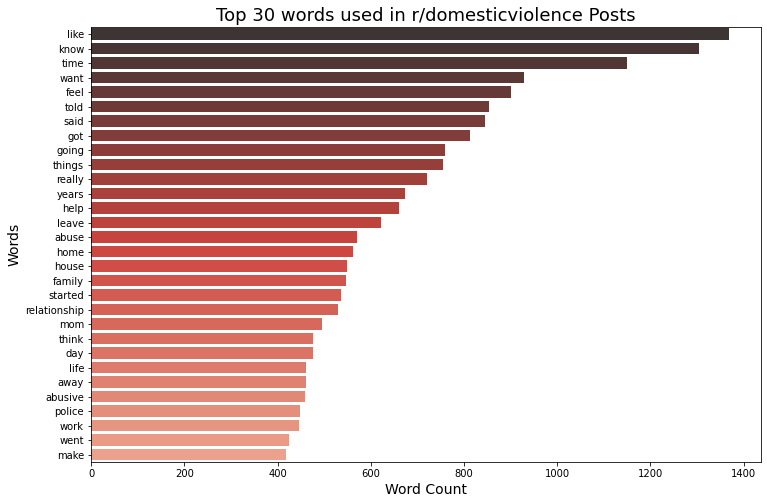

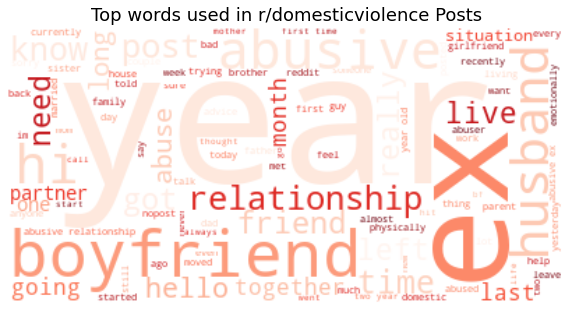

In [20]:
plots(dv_posts, 'r/domesticviolence Posts', 'Reds','Reds_d')

#### Visualisation of top words in r/depression posts

Top words in r/depression which are unique to this subreddit, e.g., ```depression, friends, think, feeling```. This would allow the model to differentiate between r/domesticviolence and r/depression posts.

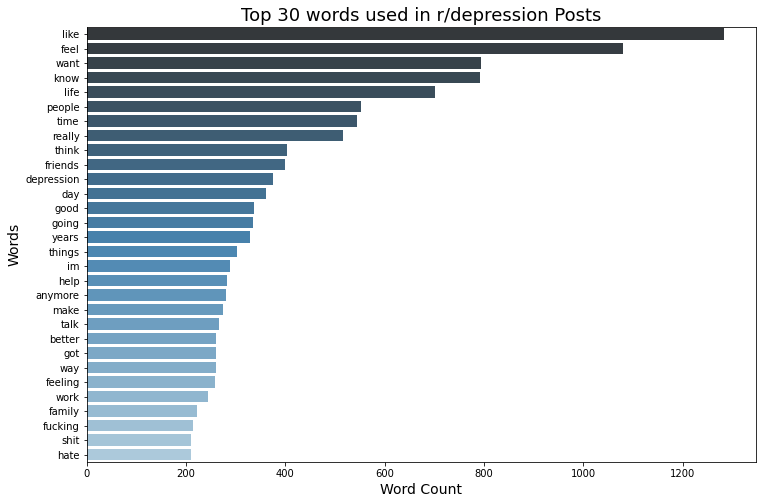

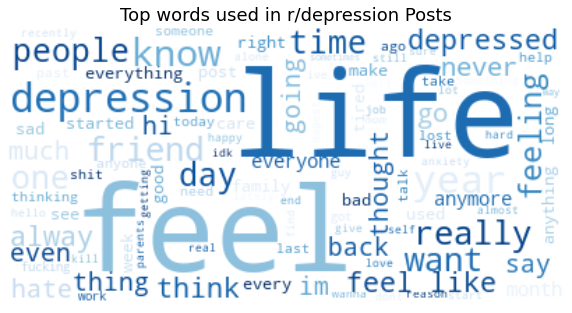

In [21]:
plots(depression_posts, 'r/depression Posts', 'Blues','Blues_d')

#### Visualisation of top words in r/domesticviolence titles

Top words in r/domesticviolence and r/depression titles which are identical, e.g., ```feel, help, think``` are fewer than identical top words in r/domesticviolence and r/depression posts. This could mean that words in titles are a better predictor of which subreddit a post belongs to.

There are many top words in r/domesticviolence titles which are unique to this subreddit, e.g., ```abuse, advice, domestic, violence, boyfriend, ex, mom, friend, relationship, police, hit, home```. This would allow the model to differentiate between r/domesticviolence and r/depression titles.

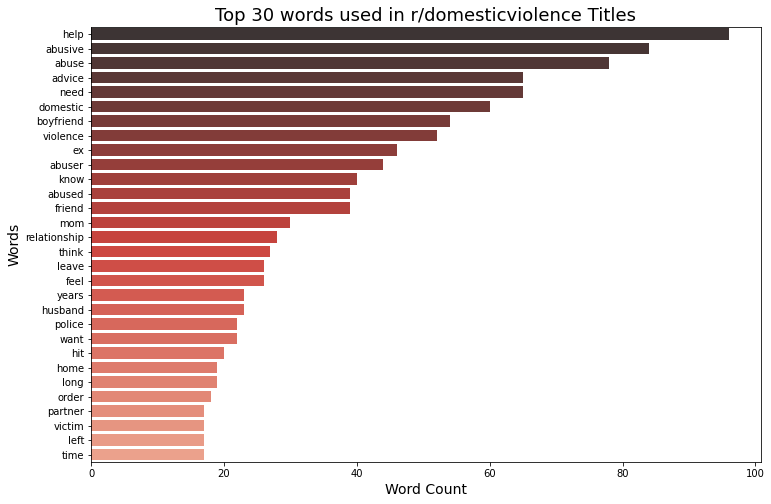

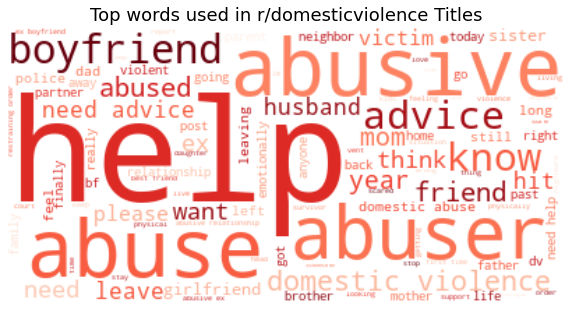

In [22]:
plots(dv_titles, 'r/domesticviolence Titles', 'Reds','Reds_d')

#### Visualisation of top words in r/depression titles

There are many top words in r/depression titles which are unique to this subreddit, e.g., ```depression, want, hate, feeling, need, die, people, self, think, suicidal, kill```. This would allow the model to differentiate between r/domesticviolence and r/depression titles.

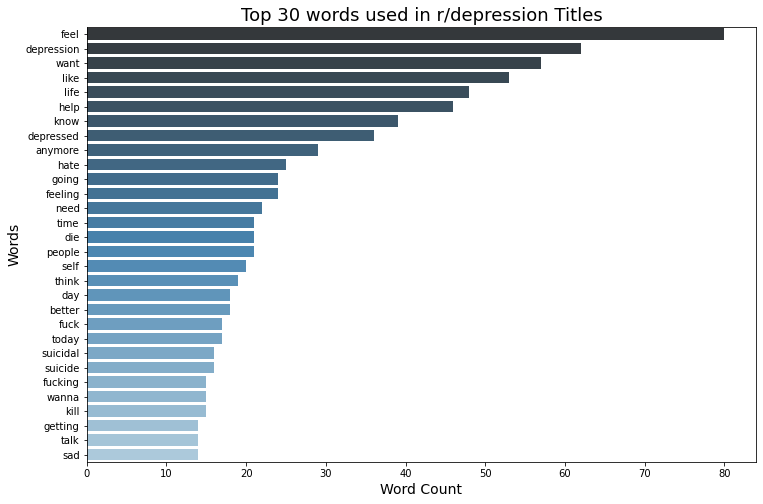

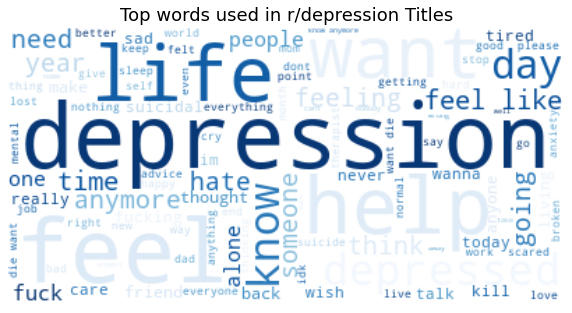

In [23]:
plots(depression_titles, 'r/depression Titles', 'Blues','Blues_d')

### Comparison of words in r/domesticviolence and r/depression 

#### Heatmap and boxplots

In [24]:
def heatmap(series_1, series_2, column):
    cvec = CountVectorizer()
    cvec.fit_transform(series_1)
    series_df_1 = pd.DataFrame(cvec.fit_transform(series_1).toarray(), 
                             columns=cvec.get_feature_names())
    wordcount_df_1 = pd.DataFrame(series_df_1.sum().sort_values(ascending=False).head(30), 
                                  columns=['count'])
    
    cvec = CountVectorizer(stop_words = 'english')
    cvec.fit_transform(series_2)
    series_df_2 = pd.DataFrame(cvec.fit_transform(series_2).toarray(), 
                             columns=cvec.get_feature_names())
    wordcount_df_2 = pd.DataFrame(series_df_2.sum().sort_values(ascending=False).head(30), 
                                  columns=['count'])
    
    new_df = pd.concat([wordcount_df_1, wordcount_df_2], axis = 1)
    
    #heatmap 
    plt.figure(figsize = (15,8))
    sns.heatmap(new_df, cmap='coolwarm')
    plt.title(f'Correlation of top words in r/domesticviolence and r/depression {column}', 
              fontsize= 18)
    plt.xlabel('Word Count', fontsize = 14)
    plt.ylabel('Words',fontsize = 14)


#### Heatmap to show similar high wordcount words in r/domsticviolence and r/depression posts and titles

r/domesticviolence and r/depression posts share several top words 

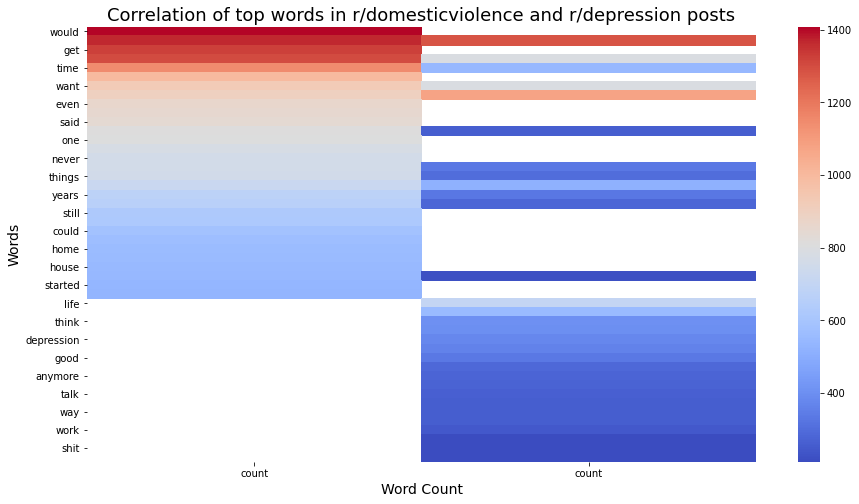

In [25]:
heatmap(dv_posts, depression_posts, 'posts')

r/domesticviolence and r/depression titles share several top words 

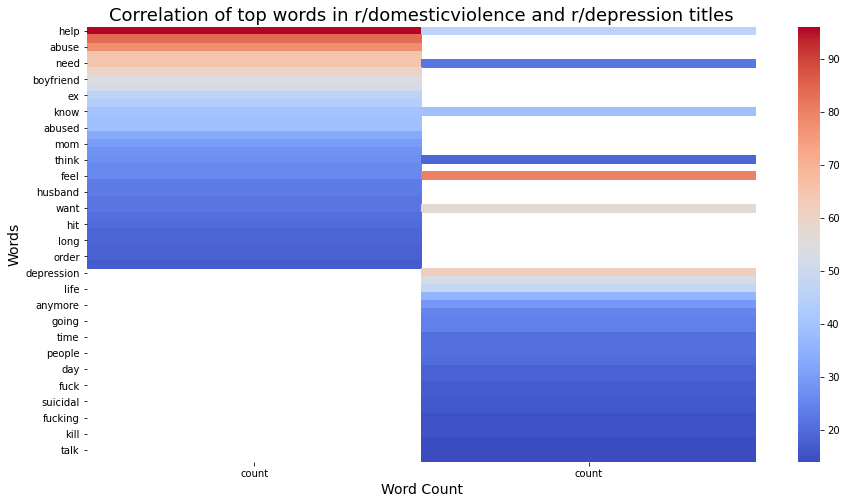

In [26]:
heatmap(dv_titles, depression_titles, 'titles')

### Visualising word counts in r/domesticviolence and r/depression posts and titles with boxplots

#### Boxplot comparing word counts in r/domesticviolence and r/depression posts

Posts in r/domestic violence are generally longer than posts in r/depression. The word count of the post could be an additional feature to help differentiate between the two. The outlier post with around 15000 words r/depression will be removed

Mean word count for posts 
- r/depression: 533.20
- r/domesticviolence: 1061.48

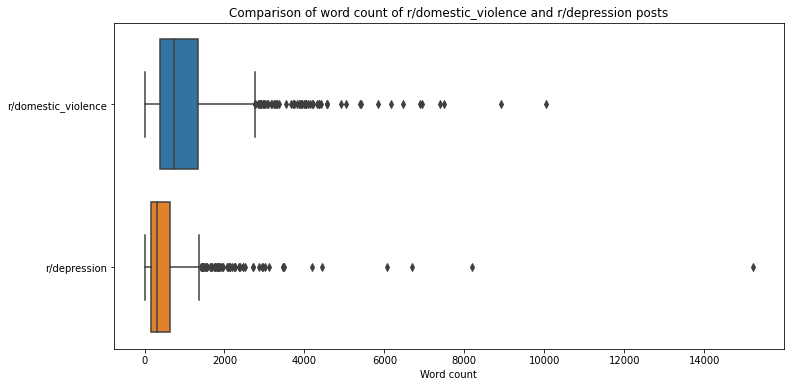

In [27]:
dv_posts_count = [len(x) for x in dv_posts]
depression_posts_count = [len(x) for x in depression_posts]
df_count_posts = pd.DataFrame([dv_posts_count, depression_posts_count]).T
df_count_posts.columns = ['r/domestic_violence', 'r/depression']
plt.figure(figsize = (12,6))
sns.boxplot(data = df_count_posts, orient = 'h')
plt.title('Comparison of word count of r/domestic_violence and r/depression posts')
plt.xlabel('Word count');

In [28]:
print(f'mean word count for posts in r/depression {np.mean(depression_posts_count)}')
print(f'mean word count for posts in r/domesticviolence {np.mean(dv_posts_count)}')

mean word count for posts in r/depression 533.1979166666666
mean word count for posts in r/domesticviolence 1061.4799599198398


#### Boxplot comparing word counts in r/domesticviolence and r/depression titles

Although r/domesticviolence titles are generally longer than r/depression titles, the difference is not as significant as the word count difference for posts

Mean word count for titles 
- r/depression: 24.15
- r/domesticviolence: 29.27

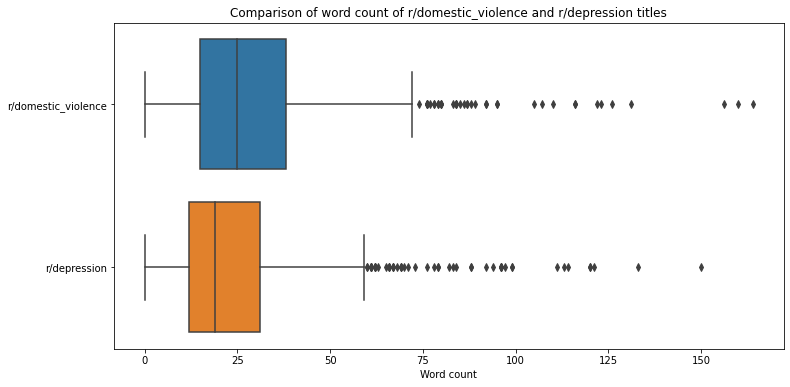

In [29]:
dv_titles_count = [len(x) for x in dv_titles]
depression_titles_count = [len(x) for x in depression_titles]
df_count_titles = pd.DataFrame([dv_titles_count, depression_titles_count]).T
df_count_titles.columns = ['r/domestic_violence', 'r/depression']
plt.figure(figsize = (12,6))
sns.boxplot(data = df_count_titles, orient = 'h')
plt.title('Comparison of word count of r/domestic_violence and r/depression titles')
plt.xlabel('Word count');

In [30]:
print(f'mean word count for titles in r/depression {np.mean(depression_titles_count)}')
print(f'mean word count for titles in r/domesticviolence {np.mean(dv_titles_count)}')

mean word count for titles in r/depression 24.152083333333334
mean word count for titles in r/domesticviolence 29.272545090180362


#### Investigating if there are authors who posted in both r/domesticviolence and r/depression

There are no authors who posted on both subreddits, even though it was found that the words in both subreddits share some similarities, i.e., r/domesticviolence posts contain words usually found in r/depression posts.

This shows that some authors who post in r/domesticviolence could be suffering from depression, but may not be given any help or support to since they did not post in the r/depression subreddit. 

In [31]:
author_dv = combined_dv_depression['author_fullname'][combined_dv_depression['is_depression'] == 0]
author_dep = combined_dv_depression['author_fullname'][combined_dv_depression['is_depression'] == 1]

print(f' number of r/depression authors who posted in r/domesticviolence = {author_dep.isin(author_dv).sum()}')
print(f' number of r/domesticviolence authors who posted in r/depression = {author_dv.isin(author_dep).sum()}')

 number of r/depression authors who posted in r/domesticviolence = 0
 number of r/domesticviolence authors who posted in r/depression = 0


---
## Feature engineering for modeling 

- Drop ```subreddit```, ```author_fullname```, ```selftext```, ```title``` columns 
    - ```selftext_clean``` and ```title_clean``` already present 
    - ```is_depression``` is a binary equivalent of ```subreddit``` column
    - ```author_fullname``` not needed for modeling since EDA showed that there were no overlaps in authors for the 2 subreddits

- Add new column ```post_word_count``` which shows total length of ```selftext_clean``` column

In [32]:
combined_dv_depression.head(2)

,subreddit,author_fullname,selftext,title,is_depression,selftext_clean,title_clean
0,domesticviolence,t2_2egrzrvq,We know many of you are struggling to manage w...,COVID-19 RESOURCES FOR ABUSE VICTIMS,0,know many struggling manage already traumatic ...,covid 19 resources abuse victims
1,domesticviolence,t2_6dnmfknj,Maybe this doesnt belong here Im not sure wher...,Im stupid. How long to feel better after minor...,0,maybe doesnt belong im sure label since im kin...,im stupid long feel better minor strangulation


In [33]:
#dropping 'subreddit', 'author_fullname', selftext', 'title' columns
combined_dv_depression.drop(['subreddit', 'author_fullname', 'selftext', 'title'], axis =1, inplace=True)
combined_dv_depression.head(2)

,is_depression,selftext_clean,title_clean
0,0,know many struggling manage already traumatic ...,covid 19 resources abuse victims
1,0,maybe doesnt belong im sure label since im kin...,im stupid long feel better minor strangulation


In [34]:
#rename selftext_clean to post and title_clean to title
combined_dv_depression.rename(columns = {'selftext_clean': 'post', 'title_clean': 'title'},
                             inplace=True)
combined_dv_depression.head(2)

,is_depression,post,title
0,0,know many struggling manage already traumatic ...,covid 19 resources abuse victims
1,0,maybe doesnt belong im sure label since im kin...,im stupid long feel better minor strangulation


In [35]:
#adding colummns which reflects word count for 'post'
combined_dv_depression['post_word_count'] = [len(x) for x in combined_dv_depression['post']]

In [36]:
#shuffling rows in combined_dv_depression
combined_dv_depression = combined_dv_depression.sample(frac=1)
combined_dv_depression.head(2)

,is_depression,post,title,post_word_count
279,0,went boyfriend visit friends got really drunk ...,really needed get mind,587
1279,1,really work die reason even carry every single...,life,228


In [37]:
combined_dv_depression.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1958 entries, 279 to 915
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   is_depression    1958 non-null   int64 
 1   post             1958 non-null   object
 2   title            1958 non-null   object
 3   post_word_count  1958 non-null   int64 
dtypes: int64(2), object(2)
memory usage: 76.5+ KB


In [38]:
#export data for modeling 
combined_dv_depression.to_csv('./data/dv_depression_cleaned_for_model.csv', index=False)

---
## Conclusion

Having done the data cleaning, preprocessing and EDA for the dataset, I will now proceed to fit different models in subsequent notebooks, to find the production model which will best predict r/depression and r/domestic violence posts.